# image detection CNN

*December 1, 2021*

Original version GDobler 2020

This notebook introduces the concept of a sliding window detector, using a CNN as the feature extractor and classifier for each window. 

we are reproducing https://www.nature.com/articles/s42005-020-0317-3#data-availability (partially)
To train and evaluate DeepSPM, we used a low-temperature STM with a metallic probe (Pt/Ir) to image a model sample: magnesium phthalocyanine (MgPc) molecules adsorbed on a silver surface. Such molecular systems are scientifically and technologically relevant, owing to their electronic, optical, and chemical properties29,30. 

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras # modulo per costruire la rete neurale

In [ ]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["image.interpolation"] = "nearest" # nearest --> no interpolation
# il valore di default per l'interpolazione può non essere questo e i pixel vengono resi smooth
plt.rcParams["image.cmap"] = "gist_gray"

plt.rcParams["image.interpolation"] default: 'antialiased'

interpolation = 'none' works well when a big image is scaled down, while interpolation = 'nearest' works well when a small image is scaled up

Let's load in the scanning probe microscope data that we used in the last assignment,

In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!ls

'Articoli Interessanti'   Cyclette	    MLPNS       Tracker.xlsx
'Colab Notebooks'	  DomandeTesi.txt   PF24        Università
'Cose Utili'		  Foto		    Queen.pdf


In [ ]:
cd MLPNS/

/content/drive/MyDrive/MLPNS


In [ ]:
ls

country_pop.xls  kaggle.json  logs/  spm/  spm-20210427T111354Z-001.zip


In [ ]:
!unzip spm-20210427T111354Z-001.zip

Archive:  spm-20210427T111354Z-001.zip
  inflating: spm/spm_struct_pos.npy  
  inflating: spm/spm_struct_neg.npy  
  inflating: spm/test_good_all.npy   
  inflating: spm/train_good_all.npy  
  inflating: spm/test_bad_all.npy    
  inflating: spm/train_bad_all.npy   


In [ ]:
# -- load data
data = np.load("spm/train_good_all.npy") # si utilizzano meno dati rispetto al set completo
# load in un numpy array

In [ ]:
data.shape

(1302, 64, 64)

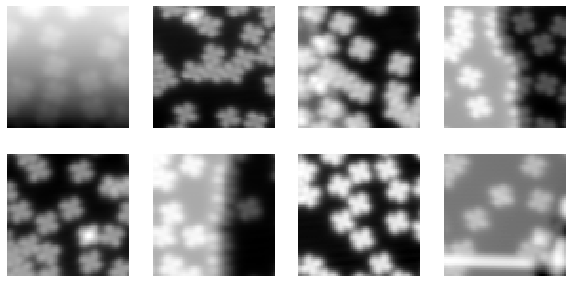

In [ ]:
# -- visualize some examples
fig, ax = plt.subplots(2, 4, figsize=[10, 5], sharex=True, sharey=True)
for ii in range(8): # plot delle prime 8 immagini
  ax[ii // 4, ii % 4].imshow(data[ii])
  ax[ii // 4, ii % 4].axis('off')
fig.show()

Our goal will be to build an **object detector** to find those magnesium phthalocyanine (MgPc) molecules in a given image.

First we normalize the images,

In [ ]:
# minmax normalize
# (data - min) / (max - min) --> valori tra 0 e 1
norm = (data - data.min(axis=(1, 2), keepdims=True)) / (data.max(axis=(1, 2), 
                        keepdims=True) - data.min(axis=(1, 2), keepdims=True))

Now we load the pre-labeled MgPc positive and negative locations,

In [ ]:
# load the good and bad locations
pos = np.load("spm/spm_struct_pos.npy")
neg = np.load("spm/spm_struct_neg.npy")

In [ ]:
pos.shape # 3 valori per riga, colonna e indice

(500, 3)

esempi positivi e negativi che danno le etichette per l'identificazione delle molecole in base alle posizioni

Using these locations, we can create postage stamps of examples of MgPc molecules and background,

si vuole identificare una singola molecola in un pezzo dell'immagine a seconda delle posizioni note

si considerano pezzi dell'immagine e si cerca la posizione delle molecole tramite le etichette positive ampliandole di 10 pixel

In [ ]:
# create good postage stamps
wid = 10
stmp_pos = []
for ii in range(pos.shape[0]):
    trow, tcol, tind = pos[ii]

    if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid): 
    # la posizione per riga e colonna deve essere > dello spessore che si vuole dare al postage stamp e minore della dimensione delle immagini
        stmp_pos.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid])
stmp_pos = np.array(stmp_pos)

In [ ]:
stmp_pos.shape

(389, 20, 20)

In [ ]:
# neg. postage stamps
stmp_neg = []
for ii in range(neg.shape[0]):
    trow, tcol, tind = neg[ii]

    if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
        stmp_neg.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid])
stmp_neg = np.array(stmp_neg)

In [ ]:
stmp_neg.shape # dimensioni dei pezzi di immagine che non contengono la molecola

(485, 20, 20)

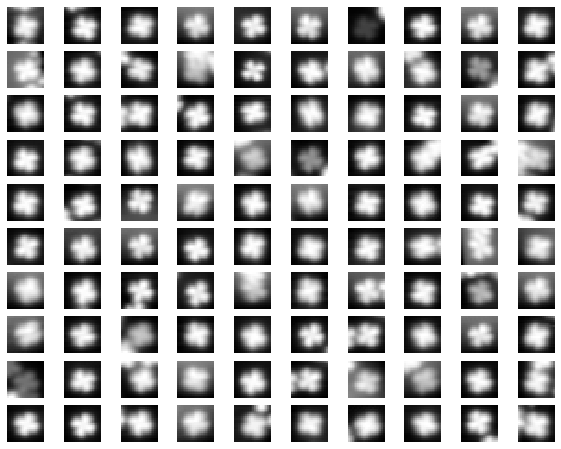

In [ ]:
# plot positive examples
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_pos[ii])
    ax[ii // 10, ii % 10].axis("off")
fig.show()

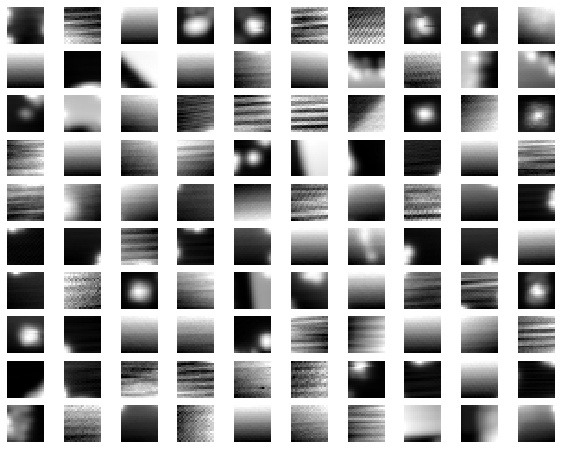

In [ ]:
# plot negative examples
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_neg[ii])
    ax[ii // 10, ii % 10].axis("off")
fig.show()

Now we build a classifier that, for a given proposal location, would classify a positive or negative MgPc detection,

# create training test set

In [ ]:
#  create a training/testing set
feat = np.concatenate((stmp_neg, stmp_pos), axis=0) # si concatenano tutti i postage stamps
targ = np.concatenate((np.zeros(stmp_neg.shape[0]), np.ones(stmp_pos.shape[0]))) # si associa 0 ai negativi e 1 ai positivi
feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ, random_state=302, shuffle=True)
# need to add an axis: tensorflow keras expexts images that are 3d: rows, columns, layers (e.g. RGB)
feat_tr = np.expand_dims(feat_tr, axis=3) 
# si aggiunge una terza dimensione corrispondente all'RGB perchè l'architettura di tensorflow è basata sul jpeg, anche se l'immagine è in bianco e nero
feat_te = np.expand_dims(feat_te, axis=3)
#feat_te.reshape(feat_te.shape[0], feat_te.shape[1], feat_te.shape[2], 1)

In [ ]:
feat_tr.shape

(655, 20, 20, 1)

# create model architecture

In [ ]:
# -- build a simple CNN (Convolutional Neural Network)

# ci sono molti tipi di layers che si possono incorporare (keras.layers. --> elenco)
# il primo parametro è il numero di neuroni, il secondo è la dimensione dell'elemento per la convoluzione (matrice che si fa scorrere sull'immagine)
# padding: come si tagliano pezzi dell'immagine che non fittano la convoluzione
# si seleziona la funzione di attivazione per il layer, in questo caso relu
# regularizer per controllare l'overfitting
layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             input_shape=(2 * wid, 2 * wid, 1), 
                             kernel_regularizer=keras.regularizers.l2(0.001))

# altri layers:
layer2 = keras.layers.MaxPool2D(2)
layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             kernel_regularizer=keras.regularizers.l2(0.001))
layer4 = keras.layers.MaxPool2D(2)
layer5 = keras.layers.Flatten() # dim 1
layer6 = keras.layers.Dense(64, activation="relu",
                            kernel_regularizer=keras.regularizers.l2(0.001)) # si riduce la dimensione per arrivare a 2 al layer successivo
layer7 = keras.layers.Dense(2, activation="softmax") # size 2 per avere un output binario
# softmax per avere un output probabilistico
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]


In [ ]:
# per la grafica
!mkdir -p logs/fit
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# run model

In [ ]:
# instantiate the model
model = keras.Sequential(layers) # sequential e non ricorsivo o a loop

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                51264     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

https://keras.rstudio.com/reference/fit.html

Epoch 1/50
12/12 [==============================] - 2s 102ms/step - loss: 0.7366 - accuracy: 0.6679 - val_loss: 0.4964 - val_accuracy: 0.8939
Epoch 2/50
12/12 [==============================] - 0s 41ms/step - loss: 0.5284 - accuracy: 0.9055 - val_loss: 0.4152 - val_accuracy: 0.8636
Epoch 3/50
12/12 [==============================] - 0s 42ms/step - loss: 0.4069 - accuracy: 0.8879 - val_loss: 0.3267 - val_accuracy: 0.8939
Epoch 4/50
12/12 [==============================] - 0s 41ms/step - loss: 0.3074 - accuracy: 0.9205 - val_loss: 0.3132 - val_accuracy: 0.8939
Epoch 5/50
12/12 [==============================] - 0s 42ms/step - loss: 0.2946 - accuracy: 0.9376 - val_loss: 0.3309 - val_accuracy: 0.9242
Epoch 6/50
12/12 [==============================] - 0s 41ms/step - loss: 0.2912 - accuracy: 0.9333 - val_loss: 0.2747 - val_accuracy: 0.9091
Epoch 7/50
12/12 [==============================] - 1s 45ms/step - loss: 0.2272 - accuracy: 0.9526 - val_loss: 0.2372 - val_accuracy: 0.9091
Epoch 8/50
1

Text(0.5, 0, 'epoch')

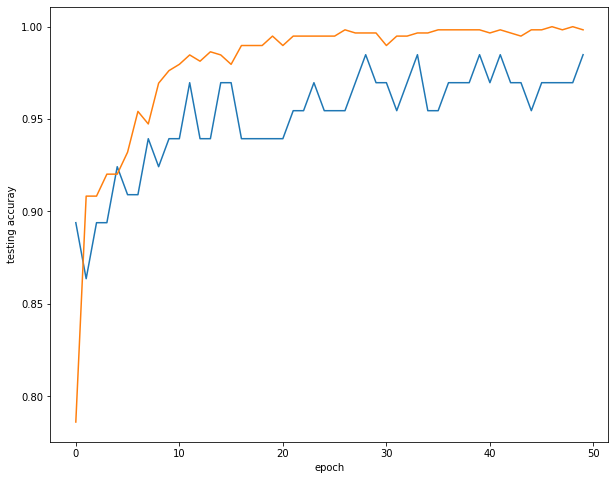

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# scelta della loss function
# metrics per valutare come si sta comportando il modello

# fit the model
history = model.fit(feat_tr, targ_tr, epochs=50, validation_split=0.1, batch_size=50,
                   callbacks=[tensorboard_callback])
# validation: dati separati per il training e la validazione
# batch_size: bootstrapping
# callbacks: visual graphic

# -- print the accuracy
loss_tr, acc_tr = model.evaluate(feat_tr, targ_tr)
loss_te, acc_te = model.evaluate(feat_te, targ_te)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

# -- plot the accuracy

plt.plot(history.history["val_accuracy"]) # plot in log se non si vogliono perdere dettagli per via dell'incremento rapido iniziale
plt.plot(history.history["accuracy"])
plt.ylabel("testing accuracy")
plt.xlabel("epoch")

la loss va su e giù e non sempre viene ottimizzata

all'epoca 30 ha già imparato

accuratezza al 99 per il training e al 98 per il testing --> problema risolvibile con questa rete neurale

# examin output

In [ ]:
#!kill 496

In [ ]:
# toolkit di visualizzazione di TensorFlow
%load_ext tensorboard 
%tensorboard --logdir logs
# info sulla rete neurale

Now let's apply this classifier to one of the images,

(-0.5, 63.5, 63.5, -0.5)

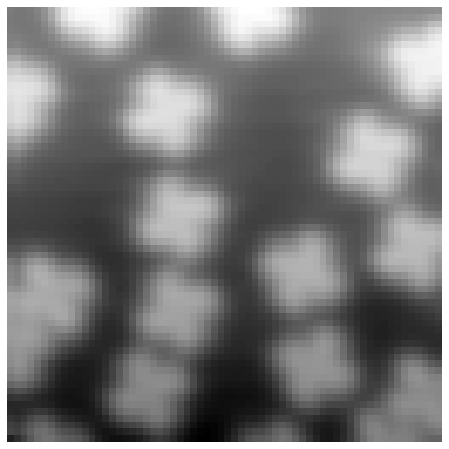

In [ ]:
# -- visualize one of the images
img = norm[51].copy()

plt.imshow(img)
plt.axis("off")

In [ ]:
# create postage stamps from image as a slider
nrow, ncol = img.shape
stamps = []
#this loops over every pixel creating a stamp centered on that pixel
for ii in range(wid, nrow - wid): #all pixel rows
  for jj in range(wid, ncol - wid): #all pixel columns
    stamps.append(img[ii-wid:ii+wid, jj-wid:jj+wid])
stamps = np.array(stamps)

si suddivide l'immagine in pezzi per ogni posizione per cui si può fittare uno stamp

In [ ]:
# -- predict all of these
feat_stmp = np.expand_dims(stamps, axis=3)
pred = model.predict(feat_stmp) # <-- si utilizza la rete neurale addestrata per predirre la presenza della molecola

In [ ]:
# -- create prediction image
pimg = np.zeros(img.shape)
# this sets each pixel to the probability that there is a molecul in the stamp centered on that pixel
pimg[wid:nrow-wid, wid:ncol-wid] = pred[:, 1].reshape(nrow - 2 * wid, ncol - 2 * wid)

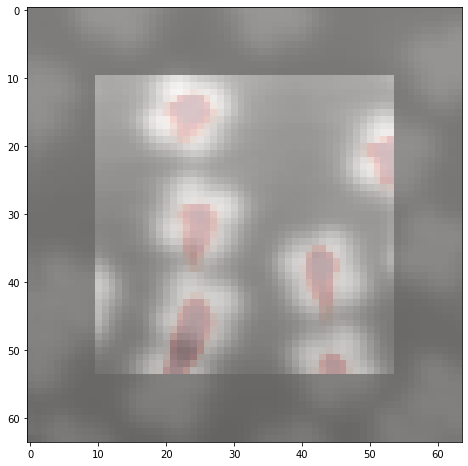

In [ ]:
# -- visualize
plt.imshow(img, alpha=0.5)
actualimg = img.copy()
actualimg[:wid,:] = 0 # si escludono i bordi che non si possono analizzare
actualimg[-wid:,:] = 0
actualimg[:,:wid] = 0
actualimg[:,-wid:] = 0
plt.imshow(actualimg, alpha=0.5)
plt.imshow(pimg, cmap="Reds", alpha=0.2) # probabilità della presenza della molecola
#plt.xlim(wid, ncol - wid)
#plt.ylim(wid, nrow - wid)

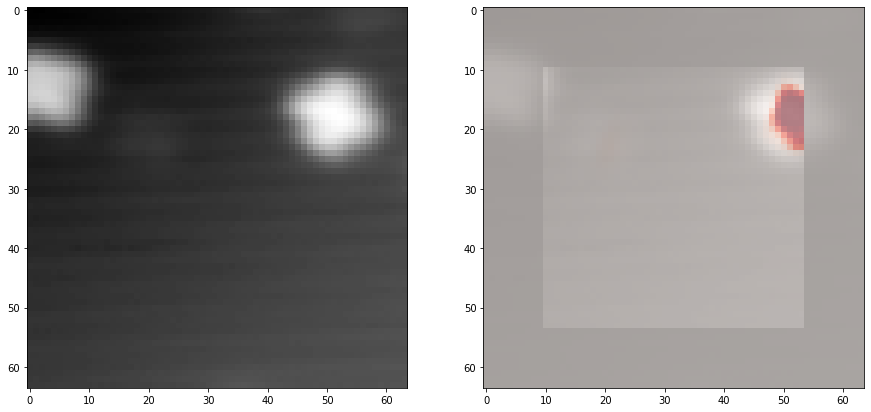

In [ ]:
# -- another example
img = norm[302].copy()

# -- create ALL the postage stamps
stamps = []
for ii in range(wid, nrow - wid):
  for jj in range(wid, ncol - wid):
    stamps.append(img[ii-wid:ii+wid, jj-wid:jj+wid])
stamps = np.array(stamps)


# -- predict all of these
feat_stmp = np.expand_dims(stamps, axis=3)
pred = model.predict(feat_stmp)


# -- create prediction image
pimg = np.zeros(img.shape)
pimg[wid:nrow-wid, wid:ncol-wid] = pred[:, 1].reshape(nrow - 2 * wid, ncol - 2 * wid)


# -- visualize
fig, ax = plt.subplots(1, 2, figsize=[15, 8])
ax[0].imshow(img)
ax[1].imshow(img, alpha=0.5)
actualimg = img.copy()
actualimg[:wid,:] = 0
actualimg[-wid:,:] = 0
actualimg[:,:wid] = 0
actualimg[:,-wid:] = 0
ax[1].imshow(actualimg, alpha=0.5)
ax[1].imshow(pimg, cmap="Reds", alpha=0.5)
#ax[0].set_xlim(wid, ncol - wid)
#ax[0].set_ylim(wid, nrow - wid)
#ax[1].set_xlim(wid, ncol - wid)
#ax[1].set_ylim(wid, nrow - wid)
fig.show()

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                51264     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

Let's see an example of the "feature vector" that is ultimately used for classification.

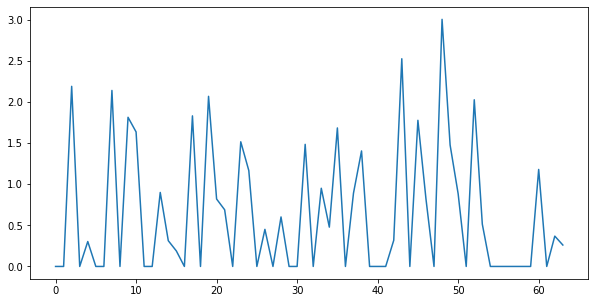

In [ ]:
# -- create the extraction model
extractor = keras.Model(inputs=model.inputs, 
                        outputs=[layer.output for layer in model.layers])

# -- get the feature vector for the various layers for the first postage stamp
fvec = extractor(stmp_pos[0:1])

# -- plot the output of the last dense layer
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(fvec[5][0])
fig.show()

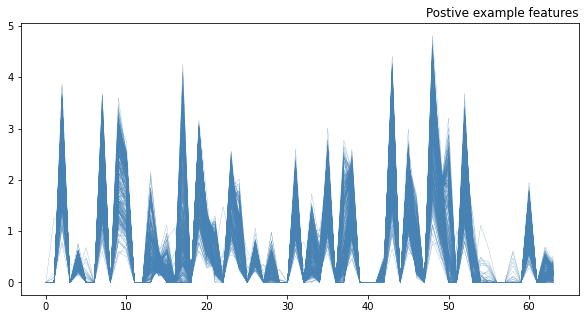

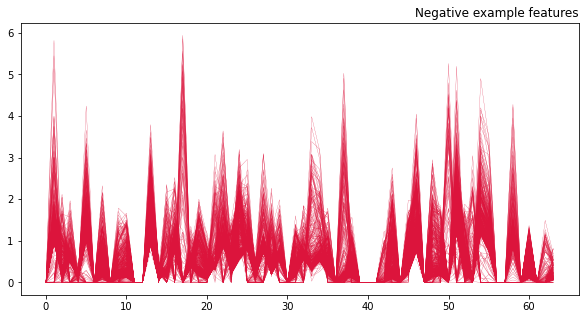

In [ ]:
# -- plot all positive example feature vectors
fvecs_pos = extractor(stmp_pos)
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(np.asarray(fvecs_pos[5]).T, color="steelblue", lw=0.2)
ax.set_title("Postive example features", loc="right")
fig.show()

# -- plot all negative example feature vectors
fvecs_neg = extractor(stmp_neg)
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(np.asarray(fvecs_neg[5]).T, color="crimson", lw=0.2)
ax.set_title("Negative example features", loc="right")
fig.show()

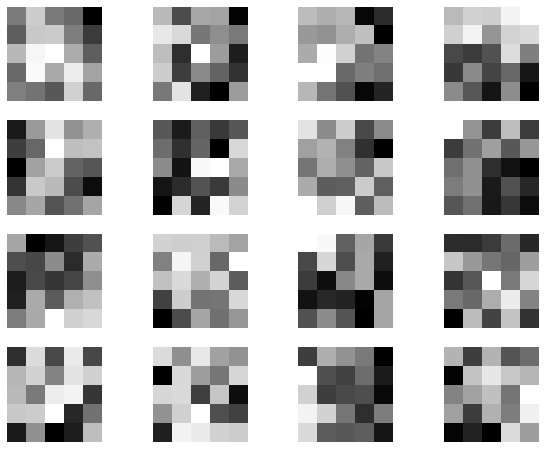

In [ ]:
tmp_ = model.layers[0]
fig, ax = plt.subplots(4, 4)
for ii in range(16):
  ax[ii // 4, ii % 4].imshow(tmp_.weights[0][:,:,0,ii])
  ax[ii // 4, ii % 4].axis("off")
  

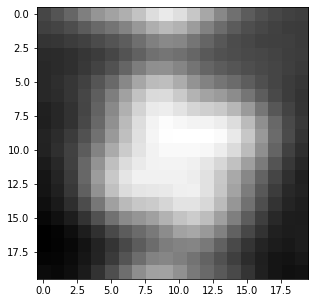

In [ ]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.imshow(stmp_pos[0])
fig.show()

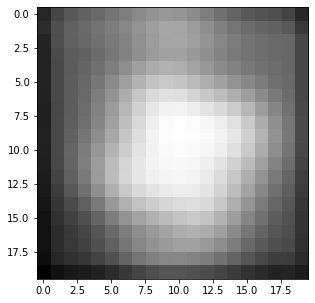

In [ ]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.imshow(fvec[0][0,:,:,0])
fig.show()

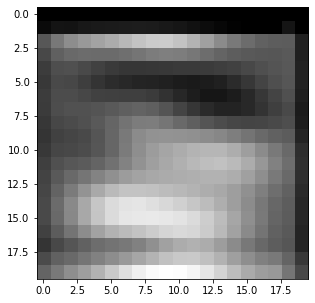

In [ ]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.imshow(fvec[0][0,:,:,3])
fig.show()

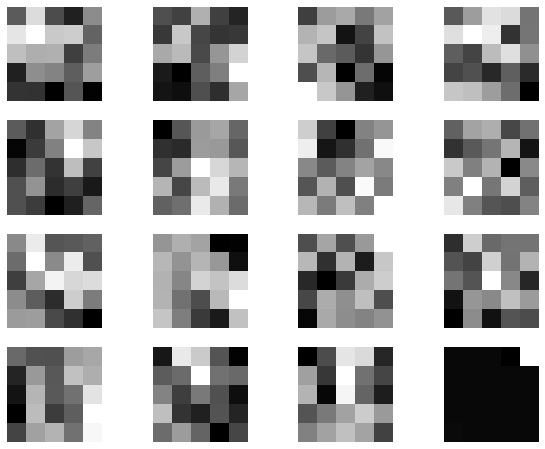

In [ ]:
tmp_ = model.layers[2]
fig, ax = plt.subplots(4, 4)
for ii in range(16):
  ax[ii // 4, ii % 4].imshow(tmp_.weights[0][:,:,0,ii])
  ax[ii // 4, ii % 4].axis("off")

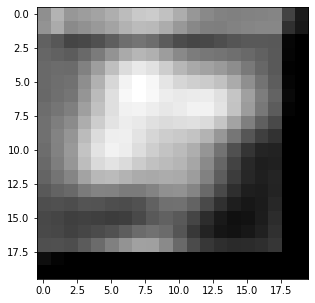

In [ ]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.imshow(fvec[0][0,:,:,8])
fig.show()

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                51264     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1